In [2]:
options(warn=-1)

In [28]:
require(XLConnect)

In [29]:
library(tidyverse)
library(reshape)
library(ggplot2)

In [30]:
library(choroplethr)

In [6]:
# install.packages('choroplethrMaps', repos='https://cran.rstudio.com')

In [7]:
library(hrbrthemes)
library(formattable)

# Daily Numbers
## Categories
This sheet shows the following observations by date:
* Posts
* Comments
* Reactions
* ActiveMembers
* Total Members
* Pending Members
* Approved Member Requests
* Declined Member Requests

## Investigation
1. It would be interesting to plot membership attributes: Total, Pending, and Declined. Maybe we can see trends of members leaving. 
1. Can we understand how active members are with posts over time in an informative way?
1. Do posts and comments vary closely?

In [8]:
wb = loadWorkbook("../data/facebook_group_insights_11-19-2017.xlsx")
lst = readWorksheet(wb, sheet = getSheets(wb))

In [9]:
lst$Posts <- NULL
lst$Contributors <- NULL
lst$`Popular Times` <- NULL
lst$`Popular Days` <- NULL

[1] "Daily Numbers"           "Members--Age and Gender"
[3] "Members--City"           "Members--Country"

In [10]:
daily.numbers = lst$`Daily Numbers`

In [11]:
glimpse(daily.numbers)

Observations: 126
Variables: 9
$ Date                     <dttm> 2017-07-13 23:00:00, 2017-07-14 23:00:00,...
$ Posts                    <dbl> 655, 415, 547, 756, 731, 697, 696, 566, 43...
$ Comments                 <dbl> 109, 55, 35, 76, 104, 61, 45, 49, 34, 106,...
$ Reactions                <dbl> 126, 75, 100, 117, 180, 97, 116, 118, 56, ...
$ Active.Members           <dbl> 2494, 2193, 2350, 2637, 2741, 2545, 2369, ...
$ Total.Members            <dbl> 46132, 46129, 46122, 46118, 46108, 46101, ...
$ Pending.Members          <dbl> 880, 931, 970, 998, 1038, 1082, 1123, 1164...
$ Approved.Member.Requests <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
$ Declined.Member.Requests <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...


`geom_smooth()` using method = 'loess'


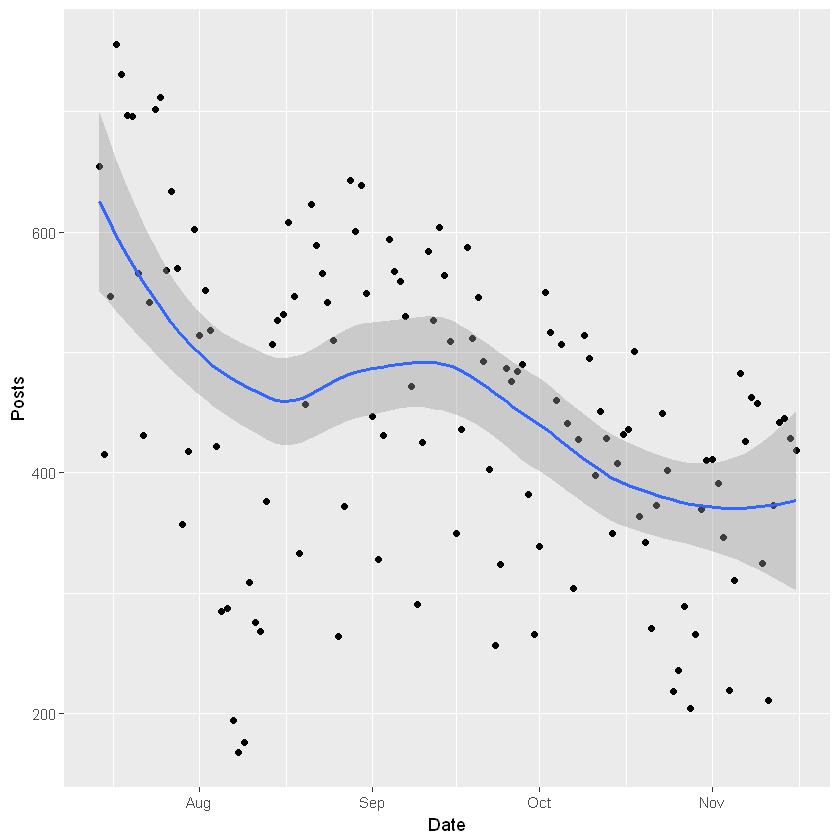

In [12]:
ggplot(daily.numbers, aes(x=Date, y=Posts)) +
  geom_point() +
  geom_smooth()

We can see that there is a TON of variance... what gives? Its because which day of the week has a huge impact. If you dont believe me just plot a line over the scatter.

Lets look at this data a different way. It would be great if there was a way to visualize this data as a calendar wouldnt it? But then how would we show varying values? A heatmap should do the trick! Sure enough there is an [easy way](http://austinwehrwein.com/data-visualization/heatmaps-with-divvy-data/) to do this in ggplot2.

In [13]:
daily.numbers<-daily.numbers %>%
  mutate(weekday=factor(weekdays(Date,T),levels = rev(c("Mon", "Tue", "Wed", "Thu","Fri", "Sat", "Sun"))))%>%
  mutate(year=format(Date,'%Y'))%>%
  mutate(week=as.numeric(format(Date,"%W")))

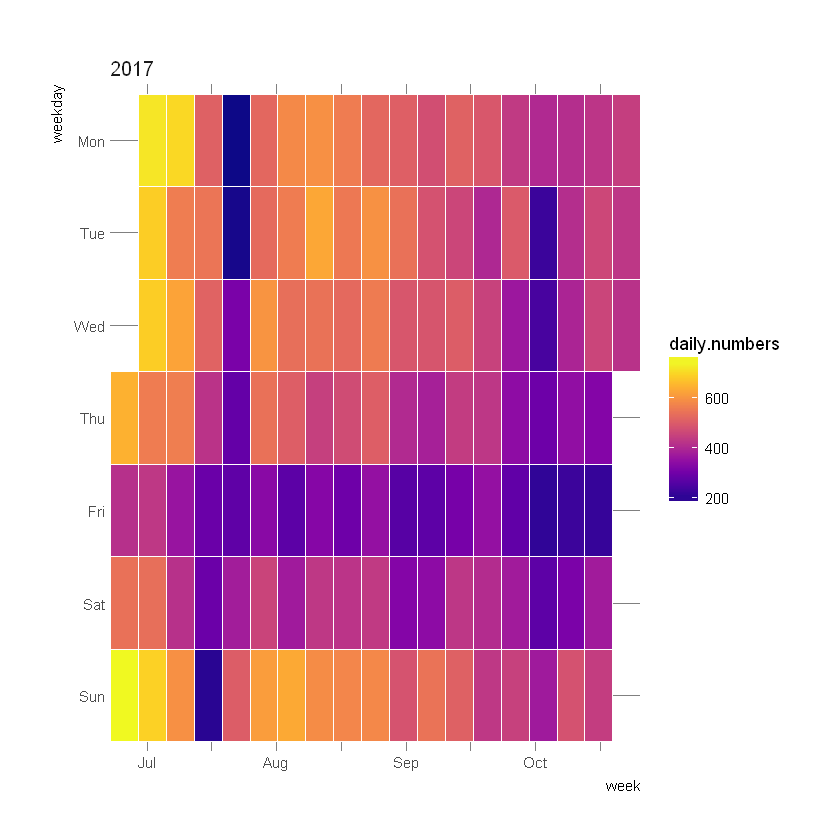

In [14]:
ggplot(daily.numbers, aes(x = week, y = weekday, fill = Posts)) +
    viridis::scale_fill_viridis(name="daily.numbers",
                       option = 'C',
                       direction = 1,
                       na.value = "grey93") +
    geom_tile(color = 'white', size = 0.1) +
    facet_wrap('year', ncol = 1) +
    scale_x_continuous(
      expand = c(0, 0),
      breaks = seq(1, 52, length = 12),
      labels = c("Jan", "Feb", "Mar", "Apr", "May", "Jun",
                 "Jul", "Aug", "Sep", "Oct", "Nov", "Dec")) +
    theme_ipsum_rc(plot_title_family = 'Slabo 27px')

In [15]:
head(daily.numbers)

Date,Posts,Comments,Reactions,Active.Members,Total.Members,Pending.Members,Approved.Member.Requests,Declined.Member.Requests,weekday,year,week
2017-07-13 23:00:00,655,109,126,2494,46132,880,0,0,Thu,2017,28
2017-07-14 23:00:00,415,55,75,2193,46129,931,0,0,Fri,2017,28
2017-07-15 23:00:00,547,35,100,2350,46122,970,0,0,Sat,2017,28
2017-07-16 23:00:00,756,76,117,2637,46118,998,0,0,Sun,2017,28
2017-07-17 23:00:00,731,104,180,2741,46108,1038,0,0,Mon,2017,29
2017-07-18 23:00:00,697,61,97,2545,46101,1082,0,0,Tue,2017,29


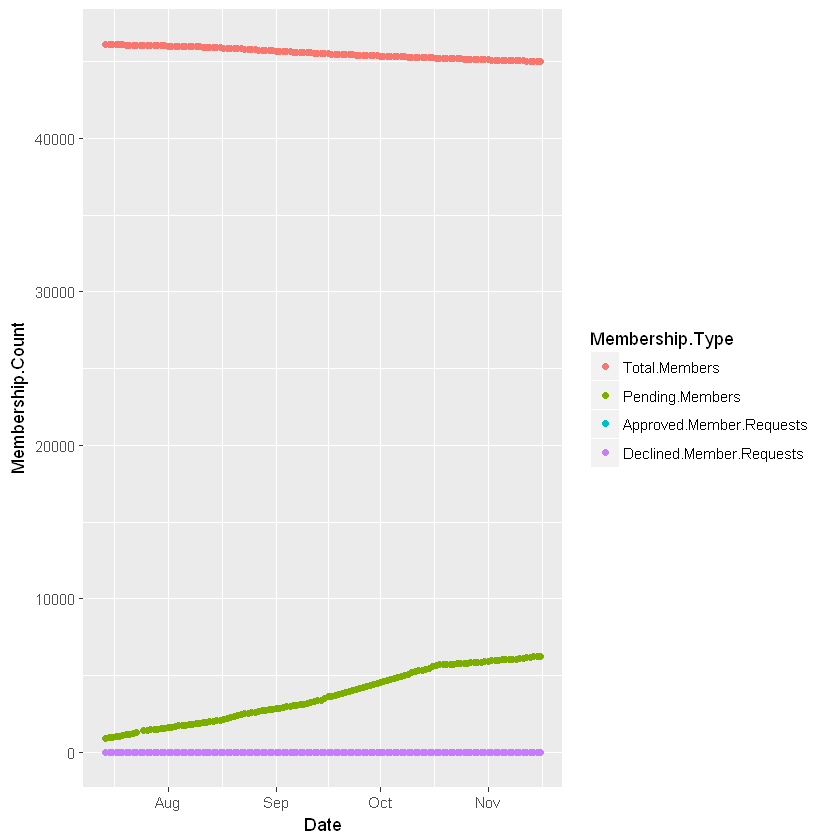

In [18]:
daily.members <- daily.numbers %>%
    reshape2:::melt.data.frame(id.vars='Date', measure.vars=c('Total.Members', 'Pending.Members', 'Approved.Member.Requests', 'Declined.Member.Requests'),
                              variable.name='Membership.Type', value.name='Membership.Count')

ggplot(daily.members, aes(x=Date, y=Membership.Count, color=Membership.Type)) +
  geom_point(aes(fill=Membership.Type))

We can see a general trend. I suspect that the data is inaccurate, so I will hold off from hardcoding my thoughts.

# Members by Age and Gender
## Investigation
It would be good to see what the distribution of gender is by age, and then understand what needs to change for diversity.

In [21]:
MAG = lst$`Members--Age and Gender`

MAG <- MAG %>%
  select(-one_of(c('X..Custom.Gender', 'X..Women', 'X..Men')))

glimpse(MAG)

Age.Range,Women,Men,Custom.Gender
13-17,127,268,0
18-24,3933,10504,14
25-34,5693,13284,8
35-44,1298,2770,4
45-54,399,702,0
55-64,209,283,0
65+,2127,3204,3


Its hard to see clearly, but I think that there are mostly Men and Women, so lets focus on that relationship. Maybe we can come up with new ideas if we plot it.

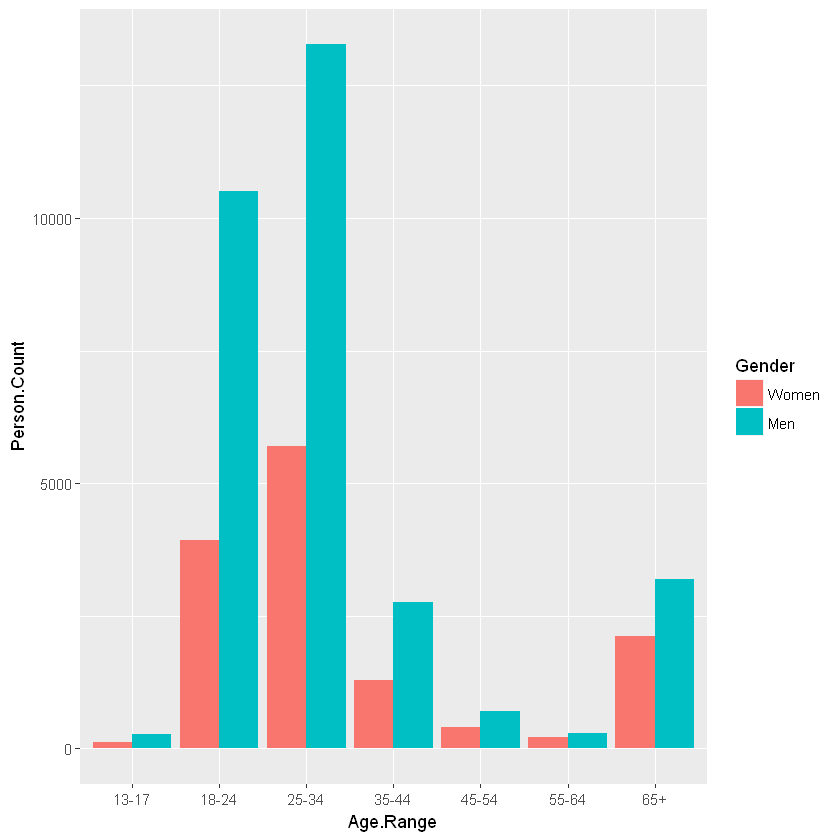

In [22]:
MAG <-
 MAG %>% select(-one_of(c('Custom.Gender')))
MAG_m <- reshape2:::melt.data.frame(MAG, id='Age.Range', variable.name='Gender', value.name='Person.Count')

ggplot(MAG_m, aes(x=Age.Range, y=Person.Count)) +
  geom_bar(aes(fill=Gender), position = "dodge", stat = "identity")

Obviously its male dominated at every age range. Is that interesting at all? Yes and no. 

* Yes
    * Its good to know
* No
    * How much will this graph change over time? 
    * If diversity is important, how can we tell if we are getting better?
    
Lets look at this from a different angle. We already know there are a lot more men. But why dont we look at how many women we expect, vs how many there are.

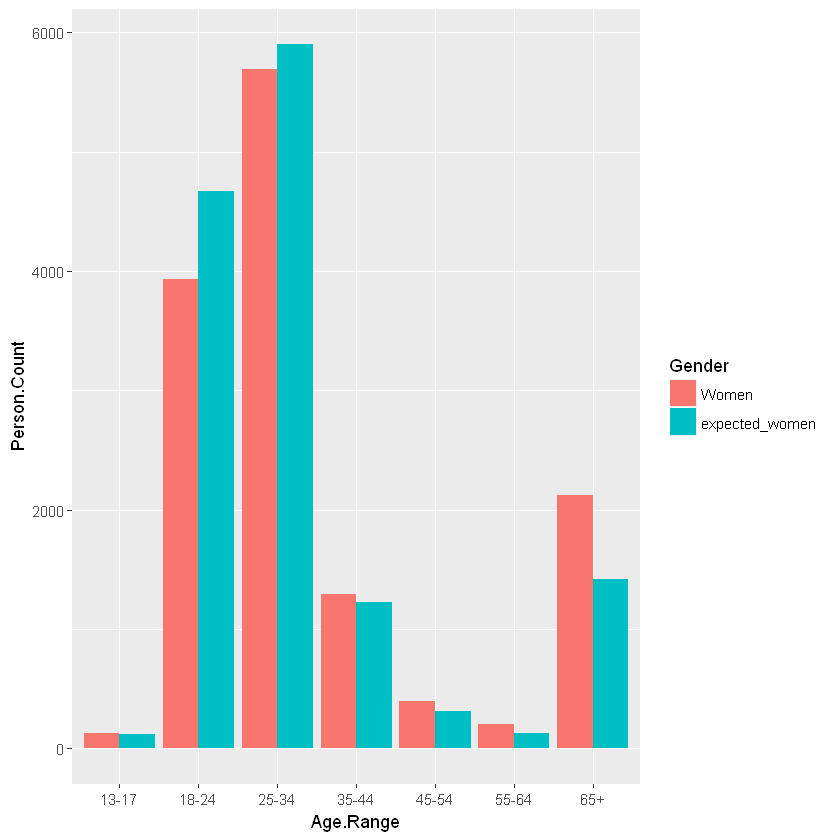

In [23]:
women_men_rat = sum(MAG$Women)/sum(MAG$Men)
MAG$expected_women = women_men_rat * MAG$Men

MAG_adjusted <- MAG %>% 
  subset(select=-Men) %>%
  reshape2:::melt.data.frame(id='Age.Range', variable.name='Gender', value.name='Person.Count')

ggplot(MAG_adjusted, aes(x=Age.Range, y=Person.Count)) +
  geom_bar(aes(fill=Gender), position = "dodge", stat = "identity")

Now we have something of interest, how many women do we expect vs how many do we have? We can see that we have more women than expected for 65+ and less than expected for 18-24. We could go more in-depth and show percentages if we were interested. 

# Members By Country
## Investigation
This is pretty straightforward data, I don't expect there is much to do except create a [choropleth](https://en.wikipedia.org/wiki/Choropleth_map), and maybe look for a better way to show Kenya, as there is a disproportionate amount of people there. Possibly a log-scale if necessary? But it might not be.

In [24]:
by.Country = lst$`Members--Country`
names(by.Country) <- c('region', 'value')
by.Country$region <- sapply(by.Country$region, tolower)
head(by.Country)

region,value
kenya,42473
united states,294
tanzania,179
qatar,170
united arab emirates,158
vietnam,155


In [25]:
by.Country$region <- recode(by.Country$region,`united states`='united states of america',`tanzania`='united republic of tanzania',`côte d\'ivoire`='ivory coast', `serbia` = 'republic of serbia') 

In [26]:
by.Country <- by.Country[ ! by.Country$region %in% c('bahrain','taiwan','mauritius','singapore','seychelles','cayman islands'), ]

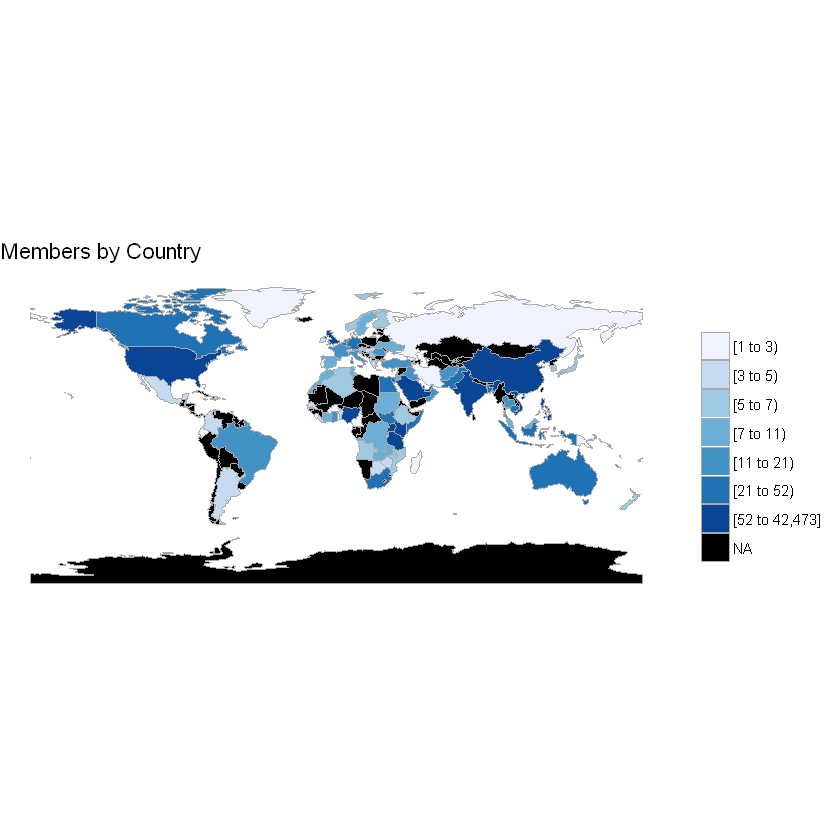

In [27]:
country_choropleth(by.Country, title='Members by Country')